# Training Pipeline

Model trained on the part 9 of the dataset https://github.com/cvdfoundation/open-images-dataset#download-images-with-bounding-boxes-annotations

## Setting up the environment

In [ ]:
model_name = "model_d_9"
saving_path = "drive/My Drive/ScalableMLDL/Progetto/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec 25 19:15:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 7.0 MB/s 


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Download data

In [ ]:
!pip install awscli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 4.9 MB/s 
     |████████████████████████████████| 662 kB 83.0 MB/s 
     |████████████████████████████████| 548 kB 86.7 MB/s 
     |████████████████████████████████| 10.3 MB 68.3 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 140 kB 77.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:


In [ ]:
!aws s3 --no-sign-request cp s3://open-images-dataset/tar/train_9.tar.gz train9

download: s3://open-images-dataset/tar/train_9.tar.gz to ./train9   


In [ ]:
!tar -xf train9

In [ ]:
!rm train9

In [ ]:
!aws s3 --no-sign-request cp s3://open-images-dataset/tar/validation.tar.gz validation

download: s3://open-images-dataset/tar/validation.tar.gz to ./validation


In [ ]:
!tar -xf validation

### Moving the data into different folders


It is required for autoencoders when using Tensorflow Image Generator

In [ ]:
!mkdir train
!mv train_9/ train/images

In [ ]:
!mv validation/ images/
!mkdir validation
!mv images/ validation/images

## Data Loader


In [ ]:
training_dir = "train"
validation_dir = "validation"

In [ ]:
interpolation = "nearest"
batch_size = 8

In [ ]:
# Create an instance of ImageDataGenerator
train_data_gen = ImageDataGenerator(rescale=1/255., # rescale value is multiplied to the image
                                    fill_mode='reflect'
                                    ) 
valid_data_gen = ImageDataGenerator(rescale=1/255., # rescale value is multiplied to the image
                                    fill_mode='reflect') 

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='input',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed,
                                               keep_aspect_ratio=True,
                                               interpolation=interpolation
                                               )
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='input',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed,
                                               keep_aspect_ratio=True,
                                               interpolation=interpolation)


Found 104514 images belonging to 1 classes.
Found 41620 images belonging to 1 classes.


(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 256, 256, 3)



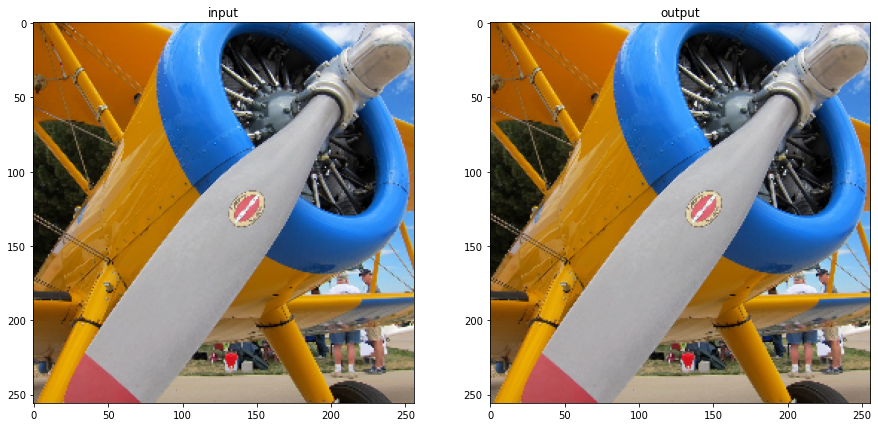

In [ ]:
# Visualize the transformation
def get_next_batch(generator):
  batch = next(generator)
  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  print()
  fig = plt.figure(figsize=(15, 10))
  fig.add_subplot(1, 2, 1)
  plt.imshow(np.uint8(image*255))
  plt.title("input")
  fig.add_subplot(1, 2, 2)
  plt.imshow(np.uint8(target*255))
  plt.title("output")
  
  return batch

  
_ = get_next_batch(train_gen) 

## Creating the model

### Models metadata

In [ ]:
input_shape = (256, 256, 3)
resized_shape = (128,128,3)
epochs = 5
patience = 1

### CNN model

In [ ]:
# building a model made by two networks: the actual autoencoder and the network with the resize layer before
def build_model(input_shape,resized_shape):
    

  
    # Build the autoencoder network
    input_autoencoder = tfkl.Input(shape=resized_shape, name='input_autoencoder')
    conv1 = tfkl.Conv2D(resized_shape[-1],kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(input_autoencoder)
    max1 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = tfkl.Conv2D(filters=16,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(max1)
    max2 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv2)
    conv3 = tfkl.Conv2D(filters=32,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(max2)
    max3 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv3)
    conv4 = tfkl.Conv2D(filters=64,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(max3)
    max4 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv4)
    conv5 = tfkl.Conv2D(filters=128,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(max4)
    max5 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv5)
    conv6 = tfkl.Conv2D(filters=256,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(max5)
    max6 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv6)
    conv7 = tfkl.Conv2D(filters=512,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(max6)
    
    fully_conv = tfkl.Conv2D(filters=1024,kernel_size=(1, 1),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(conv7)

    concatenate1 = tfkl.Concatenate(axis=-1)([fully_conv,conv7])
    transpose1= tfkl.Conv2DTranspose(filters=512,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate1)
    concatenate2 = tfkl.Concatenate(axis=-1)([transpose1,conv6])
    transpose2 = tfkl.Conv2DTranspose(filters=256,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate2)
    concatenate3 = tfkl.Concatenate(axis=-1)([transpose2,conv5])
    transpose3 = tfkl.Conv2DTranspose(filters=128,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate3)
    concatenate4 = tfkl.Concatenate(axis=-1)([transpose3,conv4])
    transpose4 = tfkl.Conv2DTranspose(filters=64,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate4)
    concatenate5 = tfkl.Concatenate(axis=-1)([transpose4,conv3])
    transpose5 = tfkl.Conv2DTranspose(filters=32,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate5)
    concatenate6 = tfkl.Concatenate(axis=-1)([transpose5,conv2])
    transpose6 = tfkl.Conv2DTranspose(filters=16,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate6)
    concatenate7 = tfkl.Concatenate(axis=-1)([transpose6,conv1])
    transpose7 = tfkl.Conv2DTranspose(filters=8,kernel_size=(3, 3),strides = (2, 2),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(concatenate7)

    ending_conv1 = tfkl.Conv2D(filters=128,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(transpose7)
    ending_conv2 = tfkl.Conv2D(filters=16,kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'relu',kernel_initializer = tfk.initializers.GlorotUniform(seed))(ending_conv1)
    output_autoencoder = tfkl.Conv2D(filters= resized_shape[-1],kernel_size=(3, 3),strides = (1, 1),padding = 'same',activation = 'sigmoid',kernel_initializer = tfk.initializers.GlorotUniform(seed))(ending_conv2)

    autoencoder_model = tfk.Model(inputs=input_autoencoder, outputs=output_autoencoder, name='autoencoder')
    autoencoder_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Build the entire network
    input_layer = tfkl.Input(shape=input_shape, name='input_resize')
    resize = tfkl.Resizing( resized_shape[-2],  resized_shape[-3], interpolation=interpolation, crop_to_aspect_ratio=True)(input_layer)
    output_layer = autoencoder_model(resize)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='with_head')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam())

    # Return the model
    return model, autoencoder_model

In [ ]:

# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join(saving_path + 'model_training')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  return callbacks

### Visualizing the model

Model: "with_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_resize (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 autoencoder (Functional)    (None, 256, 256, 3)       11563655  
                                                                 
Total params: 11,563,655
Trainable params: 11,563,655
Non-trainable params: 0
_________________________________________________________________


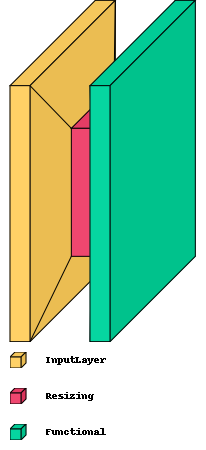

In [ ]:
# Build model
model, autoencoder_model = build_model(input_shape,resized_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_autoencoder (InputLayer)  [(None, 128, 128, 3  0          []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 3)  84          ['input_autoencoder[0][0]']      
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 3)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 16)   448         ['max_pooling2d[0][0]']

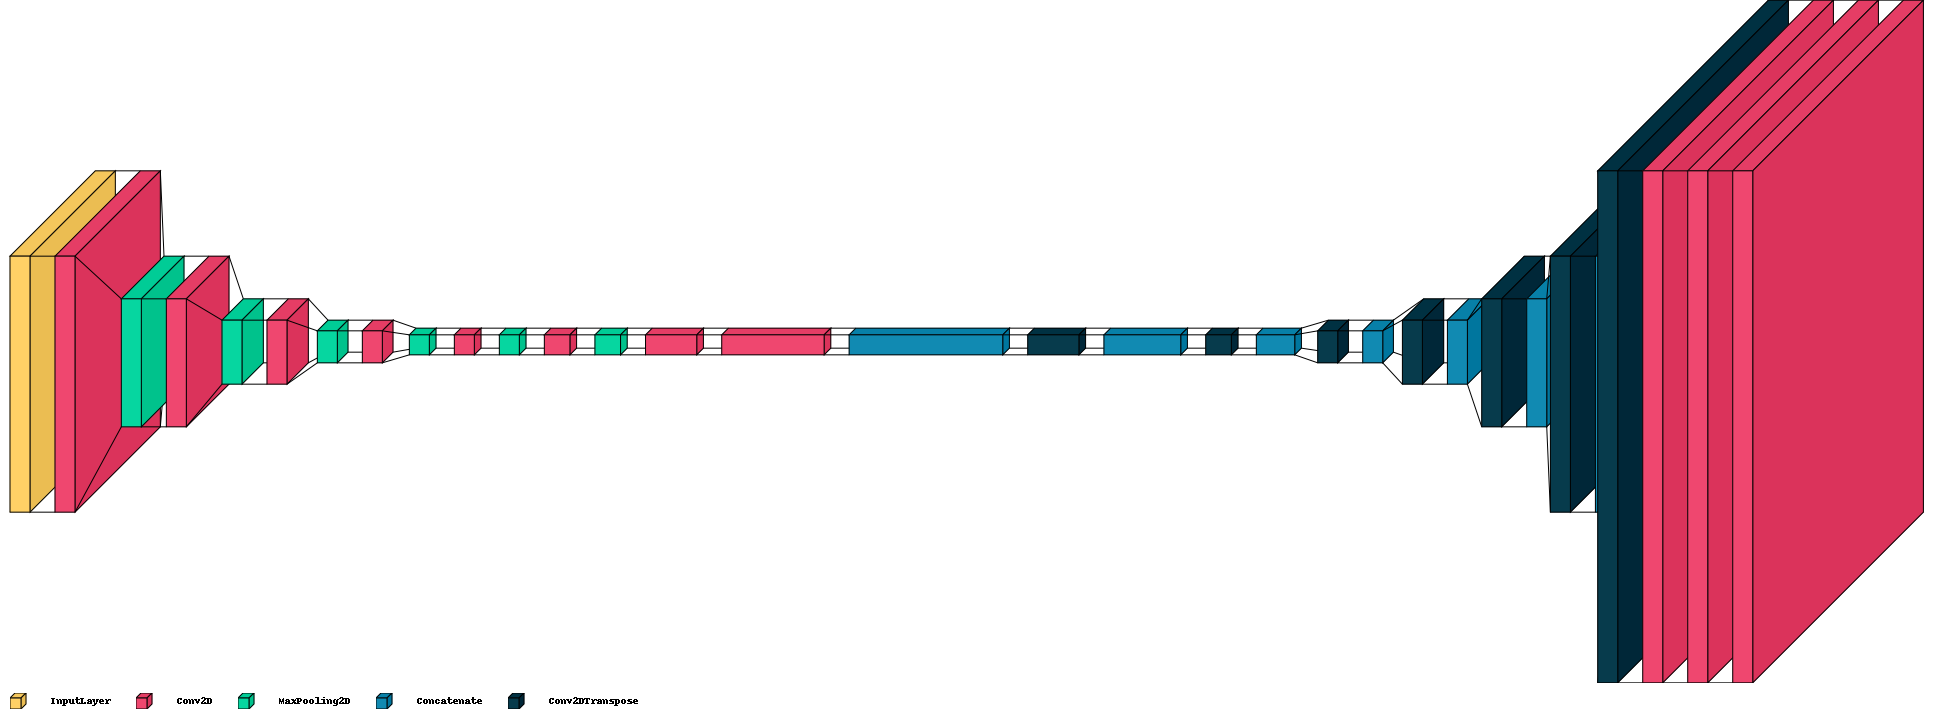

In [ ]:
autoencoder_model.summary()
visualkeras.layered_view(autoencoder_model, legend=True, spacing=25, scale_xy=2)

## Training the model

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name=model_name)

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen, # ci mette 10 minuti
    callbacks = callbacks,
).history

Epoch 1/5
13065/13065 [==============================] - ETA: 0s - loss: 0.5011

13065/13065 [==============================] - 2599s 198ms/step - loss: 0.5011 - val_loss: 0.5038
Epoch 2/5
13065/13065 [==============================] - ETA: 0s - loss: 0.4955

13065/13065 [==============================] - 2623s 201ms/step - loss: 0.4955 - val_loss: 0.5033
Epoch 3/5
13065/13065 [==============================] - ETA: 0s - loss: 0.4950

13065/13065 [==============================] - 2622s 201ms/step - loss: 0.4950 - val_loss: 0.5025
Epoch 4/5
13065/13065 [==============================] - ETA: 0s - loss: 0.4948

13065/13065 [==============================] - 2605s 199ms/step - loss: 0.4948 - val_loss: 0.5027
Epoch 5/5
13065/13065 [==============================] - ETA: 0s - loss: 0.4947

13065/13065 [==============================] - 2619s 200ms/step - loss: 0.4947 - val_loss: 0.5023


### Saving the model

In [ ]:
model.save(saving_path + model_name)
autoencoder_model.save(saving_path+"autoencoder_"+model_name)

### Visualizing training loss

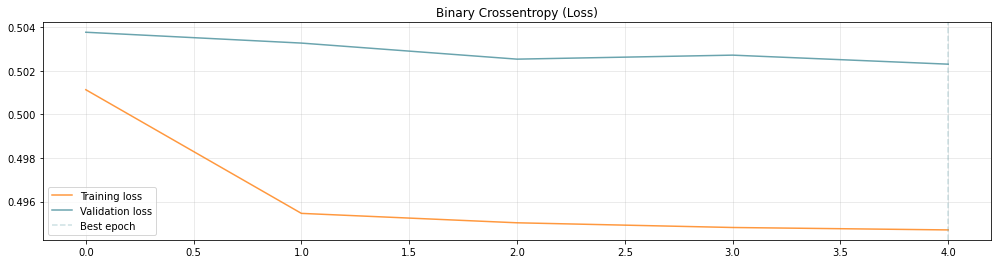

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Binary Crossentropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()